# Расчёт прогноза драйверов по эквайрингу

Загружаем необходимые библиотеки.
В данном примере подгружено больше модулей и библиотек, чем это необходимо. Какие модули/библиотеки лишние? (данное задание можно выполнить, когда вы дойдёте до конца скрипта)

In [1]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc as odbc
import numpy as np
import time
import itertools as it
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import sklearn.pipeline
import seaborn as sns
import re
from scipy import stats
from scipy import optimize
from operator import itemgetter
from sklearn import metrics, preprocessing
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import datetime as dt
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
warnings.filterwarnings('ignore')
np.random.seed(seed=321)

В нашем же случае необходимо использовать функцию pandas

In [2]:
FILE_NAME='ML_pred_stud_set1.csv'  #(в '' необходимо вставить название файла)
raw_input_df=pd.read_csv(FILE_NAME, sep=';', encoding='utf-8',header=None)

In [3]:
raw_input_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,2013-01-31,S_1,RG_1,fact,"16,9367943220774","30,03","0,919774","0,371816820666663",17,"638,9999999574",NaN,"0,998736410594576"
1,2013-01-31,S_1,RG_10,fact,"8,37216248506571","30,03","0,949844881075491","0,497901260961942",17,"182,9999999878",NaN,"0,998758954113812"
2,2013-01-31,S_1,RG_11,fact,"86,6820276497696","30,03",NaN,NaN,17,"16,4999999989",NaN,NaN
3,2013-01-31,S_1,RG_12,fact,"8,70079053480475","30,03","0,899030233884769","0,502970350269368",17,"436,4999999709",NaN,"0,998720859421024"
4,2013-01-31,S_1,RG_13,fact,"4,68245967741936","30,03","0,927184466019418","0,502216347039882",17,"131,9999999912",NaN,"0,998741966068086"


...в случае необходимости скорректируйте функцию загрузки данных и добавьте названия колонок из описания.

Произведём сброс индексов

In [4]:
raw_input_df = raw_input_df.reset_index()

In [5]:
raw_input_df.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11
0,0,2013-01-31,S_1,RG_1,fact,"16,9367943220774","30,03","0,919774","0,371816820666663",17,"638,9999999574",NaN,"0,998736410594576"
1,1,2013-01-31,S_1,RG_10,fact,"8,37216248506571","30,03","0,949844881075491","0,497901260961942",17,"182,9999999878",NaN,"0,998758954113812"
2,2,2013-01-31,S_1,RG_11,fact,"86,6820276497696","30,03",NaN,NaN,17,"16,4999999989",NaN,NaN
3,3,2013-01-31,S_1,RG_12,fact,"8,70079053480475","30,03","0,899030233884769","0,502970350269368",17,"436,4999999709",NaN,"0,998720859421024"
4,4,2013-01-31,S_1,RG_13,fact,"4,68245967741936","30,03","0,927184466019418","0,502216347039882",17,"131,9999999912",NaN,"0,998741966068086"


In [6]:
raw_input_df.columns=['index', 'report_date','segment','region','fact_progn','tranth_tst','dollar','dol_rab_ter','dol_sn_nal','rab_dney','atm','cards','compl']
raw_input_df.drop(labels=['index'], axis=1, inplace=True)

In [7]:
raw_input_df.head()

,report_date,segment,region,fact_progn,tranth_tst,dollar,dol_rab_ter,dol_sn_nal,rab_dney,atm,cards,compl
0,2013-01-31,S_1,RG_1,fact,"16,9367943220774","30,03","0,919774","0,371816820666663",17,"638,9999999574",NaN,"0,998736410594576"
1,2013-01-31,S_1,RG_10,fact,"8,37216248506571","30,03","0,949844881075491","0,497901260961942",17,"182,9999999878",NaN,"0,998758954113812"
2,2013-01-31,S_1,RG_11,fact,"86,6820276497696","30,03",NaN,NaN,17,"16,4999999989",NaN,NaN
3,2013-01-31,S_1,RG_12,fact,"8,70079053480475","30,03","0,899030233884769","0,502970350269368",17,"436,4999999709",NaN,"0,998720859421024"
4,2013-01-31,S_1,RG_13,fact,"4,68245967741936","30,03","0,927184466019418","0,502216347039882",17,"131,9999999912",NaN,"0,998741966068086"


In [8]:
# raw_input_df = raw_input_df[['report_date', 'tranth_tst', 'segment']]
# raw_input_df['tranth_tst'] = raw_input_df['tranth_tst'].astype('str').str.replace(',', '.').astype(float)
# raw_input_df['report_date'] = pd.to_datetime(raw_input_df['report_date'])
# raw_input_df = raw_input_df.groupby(['segment', 'report_date']).sum()
# raw_input_df.head()

In [9]:
# raw_input_df = raw_input_df.reset_index()
# raw_input_df.head()

In [10]:
# plt.figure(figsize = (20,5))
# # labels = []
# for item in np.unique(raw_input_df['segment']):
# #     labels.append(item)
#     df = raw_input_df[raw_input_df['segment'] == item]
#     plt.plot(df['report_date'], df['tranth_tst'], label = item)
# # plt.plot(raw_input_df['report_date'], raw_input_df['tranth_tst'])
# plt.legend()
# plt.grid(True)
# plt.show()

Скопируем сет данных

In [11]:
processed_input_df = raw_input_df.copy(deep=True)

Просмотр получившихся колонок

In [12]:
pd.DataFrame(processed_input_df.columns).rename(columns={0: 'columns'})

,columns
0,report_date
1,segment
2,region
3,fact_progn
4,tranth_tst
5,dollar
6,dol_rab_ter
7,dol_sn_nal
8,rab_dney
9,atm


Просмотр типов колонок

In [13]:
processed_input_df.dtypes

report_date    object
segment        object
region         object
fact_progn     object
tranth_tst     object
dollar         object
dol_rab_ter    object
dol_sn_nal     object
rab_dney       int64 
atm            object
cards          object
compl          object
dtype: object

Преобразуем тип данных в "object" для показателей, по которым планируется исключительно группировка 
в нашем случае это "segment"  и "region".

In [14]:
processed_input_df['segment'] = processed_input_df['segment'].astype('object')

... для показателя "region" проделайте это самостоятельно (повторите строчку выше, но уже для "region")

In [15]:
processed_input_df['region'] = processed_input_df['region'].astype('object')

В случае, если Вы считаете, что у каких-то колонок в сете данных необходимо изменить тип (например на int или float) сделайте это самостоятельно аналогичным образом.

In [16]:
# processed_input_df['tranth_tst'] = processed_input_df['tranth_tst'].astype('float')
# processed_input_df['dollar'] = processed_input_df['dollar'].astype('float')
# processed_input_df['dol_rab_ter'] = processed_input_df['dol_rab_ter'].astype('float')
# processed_input_df['dol_sn_nal'] = processed_input_df['dol_sn_nal'].astype('float')
# processed_input_df['atm'] = processed_input_df['atm'].astype('float')
# processed_input_df['cards'] = processed_input_df['cards'].astype('float')
# processed_input_df['compl'] = processed_input_df['compl'].astype('float')
# Надо заменить ',' на .

Добавьте dummy-переменные по переменным, по которым будет происходить группировка ('segment', 'region').
Вы можете сделать это следующим образом:

In [17]:
def get_numeric_columns(df):
    return [col for col in df.columns if df[col].dtype.name != 'object']

def get_nonnumeric_columns(df):
    return [col for col in df.columns if df[col].dtype.name == 'object']

def column_onehot_encoder(df, column_names_list, drop_columns=[]):
    df_describe = df[column_names_list].describe(include=[object])
    binary_categorical_columns    = [col for col in get_nonnumeric_columns(df[column_names_list]) if df_describe[col]['unique'] == 2]
    nonbinary_categorical_columns = [col for col in get_nonnumeric_columns(df[column_names_list]) if df_describe[col]['unique'] > 2]
    for col in binary_categorical_columns:
        top_value = df_describe[col]['top']
        top_elements = df[col] == top_value
        df.loc[top_elements, col] = 0
        df.loc[np.logical_not(top_elements), col] = 1
    if len(nonbinary_categorical_columns) > 0:
        df_nonbinary_categorical_columns = pd.get_dummies(df[nonbinary_categorical_columns])
        if len(drop_columns)>0:
            df.drop(nonbinary_categorical_columns, axis=1, inplace=True)
        df = pd.concat((df, df_nonbinary_categorical_columns), axis=1)
    return df

In [18]:
processed_input_df = column_onehot_encoder(df=processed_input_df, column_names_list=['segment', 'region'])
processed_input_df.head()

,report_date,segment,region,fact_progn,tranth_tst,dollar,dol_rab_ter,dol_sn_nal,rab_dney,atm,cards,compl,segment_S_1,segment_S_2,segment_S_3,segment_S_4,segment_S_5,region_RG_1,region_RG_10,region_RG_11,region_RG_12,region_RG_13,region_RG_14,region_RG_15,region_RG_16,region_RG_17,region_RG_18,region_RG_19,region_RG_2,region_RG_20,region_RG_21,region_RG_22,region_RG_23,region_RG_24,region_RG_25,region_RG_26,region_RG_27,region_RG_28,region_RG_29,region_RG_3,region_RG_30,region_RG_31,region_RG_32,region_RG_33,region_RG_34,region_RG_35,region_RG_36,region_RG_37,region_RG_38,region_RG_39,region_RG_4,region_RG_40,region_RG_41,region_RG_42,region_RG_43,region_RG_44,region_RG_45,region_RG_46,region_RG_47,region_RG_48,region_RG_49,region_RG_5,region_RG_50,region_RG_51,region_RG_52,region_RG_53,region_RG_54,region_RG_55,region_RG_56,region_RG_57,region_RG_58,region_RG_59,region_RG_6,region_RG_60,region_RG_61,region_RG_62,region_RG_63,region_RG_64,region_RG_65,region_RG_66,region_RG_67,region_RG_68,region_RG_69,region_RG_7,region_RG_70,region_RG_71,region_RG_72,region_RG_73,region_RG_74,region_RG_75,region_RG_76,region_RG_77,region_RG_78,region_RG_79,region_RG_8,region_RG_80,region_RG_81,region_RG_82,region_RG_83,region_RG_84,region_RG_85,region_RG_9
0,2013-01-31,S_1,RG_1,fact,"16,9367943220774","30,03","0,919774","0,371816820666663",17,"638,9999999574",NaN,"0,998736410594576",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-31,S_1,RG_10,fact,"8,37216248506571","30,03","0,949844881075491","0,497901260961942",17,"182,9999999878",NaN,"0,998758954113812",1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-31,S_1,RG_11,fact,"86,6820276497696","30,03",NaN,NaN,17,"16,4999999989",NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-31,S_1,RG_12,fact,"8,70079053480475","30,03","0,899030233884769","0,502970350269368",17,"436,4999999709",NaN,"0,998720859421024",1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-31,S_1,RG_13,fact,"4,68245967741936","30,03","0,927184466019418","0,502216347039882",17,"131,9999999912",NaN,"0,998741966068086",1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


либо, использовать функцию 

In [19]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder() 
example_df_=processed_input_df['segment']
LE.fit_transform(example_df_)
# в случае необходимости сделайте это самостоятельно

array([0, 0, 0, ..., 4, 4, 4])

либо

In [20]:
processed_input_df_example=pd.get_dummies(processed_input_df,columns=['segment','region'], sparse=True)

Укажите колонки (номера колонок в raw_input_df) в сете данных, которые являются срезами группировок (non_feature_columns: 'segment', 'region'),
прогнозируемой переменной (predict_columns), факторами модели (feature_columns) 
Пример:

In [21]:
raw_input_df.head()

,report_date,segment,region,fact_progn,tranth_tst,dollar,dol_rab_ter,dol_sn_nal,rab_dney,atm,cards,compl
0,2013-01-31,S_1,RG_1,fact,"16,9367943220774","30,03","0,919774","0,371816820666663",17,"638,9999999574",NaN,"0,998736410594576"
1,2013-01-31,S_1,RG_10,fact,"8,37216248506571","30,03","0,949844881075491","0,497901260961942",17,"182,9999999878",NaN,"0,998758954113812"
2,2013-01-31,S_1,RG_11,fact,"86,6820276497696","30,03",NaN,NaN,17,"16,4999999989",NaN,NaN
3,2013-01-31,S_1,RG_12,fact,"8,70079053480475","30,03","0,899030233884769","0,502970350269368",17,"436,4999999709",NaN,"0,998720859421024"
4,2013-01-31,S_1,RG_13,fact,"4,68245967741936","30,03","0,927184466019418","0,502216347039882",17,"131,9999999912",NaN,"0,998741966068086"


In [22]:
cols=raw_input_df.columns.tolist()
non_feature_columns = cols[0:3] #измените номера колонок
feature_columns = cols[3:4]
#измените номера колонок
feature_columns[1:9]=cols[5:12]
predict_columns = cols[4:5] #измените номера колонок

non_feature_columns необходимы исключительно для задач, в которых нужно получить прогнозы в различных срезах, для возможности дальнейшего анализа. Используются крайне редко, но в нашем случае они нужны. 

Формирование массивов зависимой переменной y и факторов Х, и заполнение пробелов в данных. 
В нашем случае учебный сет данных уже достаточно хороший, но всё равно это делать нужно. 

In [23]:
X = processed_input_df.drop(predict_columns,axis=1)
X=X.fillna(0)
y = processed_input_df[non_feature_columns+predict_columns]
y=y.fillna(0)

In [24]:
y.describe()

,report_date,segment,region,tranth_tst
count,21392,21392,21392,21392
unique,60,5,85,20778
top,2017-12-31,S_3,RG_9,"0,161290322580645"
freq,373,5030,300,17


... в фрейме выше введите вместо ###
тот показатель которым Вы считаете правильно заменить пропуски (например 0 или avg() или какой-то другой). Попробуйте самостоятельно определить чем лучше заполнять пропуски в нашем примере.

Просмотр характеристик прогнозируемой переменной

In [25]:
y.describe()

,report_date,segment,region,tranth_tst
count,21392,21392,21392,21392
unique,60,5,85,20778
top,2017-12-31,S_3,RG_9,"0,161290322580645"
freq,373,5030,300,17


Далее добавим авторегрессионные лаги.
Пример добавления лагов:

In [26]:
def shifted_features_tsd(X, y, lag_start=5, lag_end=17,
                         process_X=[], process_y=[], drop_columns=[],
                         sorted_by=[], grouped_by=[], reset_lag_idx=True):
    X_, y_ = pd.DataFrame(X.copy()), pd.DataFrame(y.copy())
    for i in range(lag_start, lag_end+1):
        if reset_lag_idx:
            idx = i-lag_start+1
        else:
            idx = i
        for col in process_X:
            if len(sorted_by) == 0:
                X_['lag_{}_{}'.format(col, idx)] = X_[col].shift(i)
            else:
                X_['lag_{}_{}'.format(col, idx)] = X_.sort_values(by=sorted_by, ascending=True).groupby(grouped_by)[col].shift(i)
        for col in process_y:
            if len(sorted_by) == 0:
                X_['lag_{}_{}'.format(col, idx)] = y_[col].shift(i)
            else:
                X_['lag_{}_{}'.format(col, idx)] = y_.sort_values(by=sorted_by, ascending=True).groupby(grouped_by)[col].shift(i)
    X_.drop(drop_columns, axis=1, inplace=True)
    df = X_.join(y_.drop(sorted_by, axis=1)).dropna()
    df.reset_index(drop=True, inplace=True)
    return df[X_.columns], df[y_.drop(sorted_by, axis=1).columns]

...номера столбцов в process_X=[] и  drop_columns=[] соответствуют тем столбцам, по которым мы производим лагогенерацию. Вставьте в фрейме выше те номера колонок, которые нужны для нашей задачи.
Либо, вместо лагогенерации можно добавить dummy-переменные на месяца (мы заранее знаем, что наша сезонность имеет цикл 12 месяцев).

In [27]:
LAG_START = 1
LAG_END = LAG_START+12
X, y = shifted_features_tsd(X=X, y=y, lag_start=LAG_START, lag_end=LAG_END, \
                            process_X=[feature_columns[0],feature_columns[1],feature_columns[2],feature_columns[3],feature_columns[4],feature_columns[5],feature_columns[6]], process_y=[predict_columns[0]], \
                            drop_columns=[feature_columns[0],feature_columns[1],feature_columns[2],feature_columns[3],feature_columns[4],feature_columns[5],feature_columns[6]],\
                            sorted_by=['report_date','segment', 'region'],\
                            grouped_by=['segment', 'region'], reset_lag_idx=True)

In [28]:
X['report_date']=pd.to_datetime(X['report_date'])

In [29]:
from sklearn.preprocessing import LabelEncoder
import calendar
oh =LabelEncoder()
oh.fit_transform(X['report_date'].dt.month)

array([ 1,  1,  1, ..., 11, 11, 11])

либо

In [30]:
month_name=pd.get_dummies(X['report_date'].dt.month, sparse=True)

... не забудьте добавить их в Х=X+month_name

У нас получились следующие факторы модели

In [31]:
X.tail(0)

,report_date,segment,region,compl,segment_S_1,segment_S_2,segment_S_3,segment_S_4,segment_S_5,region_RG_1,region_RG_10,region_RG_11,region_RG_12,region_RG_13,region_RG_14,region_RG_15,region_RG_16,region_RG_17,region_RG_18,region_RG_19,region_RG_2,region_RG_20,region_RG_21,region_RG_22,region_RG_23,region_RG_24,region_RG_25,region_RG_26,region_RG_27,region_RG_28,region_RG_29,region_RG_3,region_RG_30,region_RG_31,region_RG_32,region_RG_33,region_RG_34,region_RG_35,region_RG_36,region_RG_37,region_RG_38,region_RG_39,region_RG_4,region_RG_40,region_RG_41,region_RG_42,region_RG_43,region_RG_44,region_RG_45,region_RG_46,region_RG_47,region_RG_48,region_RG_49,region_RG_5,region_RG_50,region_RG_51,region_RG_52,region_RG_53,region_RG_54,region_RG_55,region_RG_56,region_RG_57,region_RG_58,region_RG_59,region_RG_6,region_RG_60,region_RG_61,region_RG_62,region_RG_63,region_RG_64,region_RG_65,region_RG_66,region_RG_67,region_RG_68,region_RG_69,region_RG_7,region_RG_70,region_RG_71,region_RG_72,region_RG_73,region_RG_74,region_RG_75,region_RG_76,region_RG_77,region_RG_78,region_RG_79,region_RG_8,region_RG_80,region_RG_81,region_RG_82,region_RG_83,region_RG_84,region_RG_85,region_RG_9,lag_fact_progn_1,lag_dollar_1,lag_dol_rab_ter_1,lag_dol_sn_nal_1,lag_rab_dney_1,lag_atm_1,lag_cards_1,lag_tranth_tst_1,lag_fact_progn_2,lag_dollar_2,lag_dol_rab_ter_2,lag_dol_sn_nal_2,lag_rab_dney_2,lag_atm_2,lag_cards_2,lag_tranth_tst_2,lag_fact_progn_3,lag_dollar_3,lag_dol_rab_ter_3,lag_dol_sn_nal_3,lag_rab_dney_3,lag_atm_3,lag_cards_3,lag_tranth_tst_3,lag_fact_progn_4,lag_dollar_4,lag_dol_rab_ter_4,lag_dol_sn_nal_4,lag_rab_dney_4,lag_atm_4,lag_cards_4,lag_tranth_tst_4,lag_fact_progn_5,lag_dollar_5,lag_dol_rab_ter_5,lag_dol_sn_nal_5,lag_rab_dney_5,lag_atm_5,lag_cards_5,lag_tranth_tst_5,lag_fact_progn_6,lag_dollar_6,lag_dol_rab_ter_6,lag_dol_sn_nal_6,lag_rab_dney_6,lag_atm_6,lag_cards_6,lag_tranth_tst_6,lag_fact_progn_7,lag_dollar_7,lag_dol_rab_ter_7,lag_dol_sn_nal_7,lag_rab_dney_7,lag_atm_7,lag_cards_7,lag_tranth_tst_7,lag_fact_progn_8,lag_dollar_8,lag_dol_rab_ter_8,lag_dol_sn_nal_8,lag_rab_dney_8,lag_atm_8,lag_cards_8,lag_tranth_tst_8,lag_fact_progn_9,lag_dollar_9,lag_dol_rab_ter_9,lag_dol_sn_nal_9,lag_rab_dney_9,lag_atm_9,lag_cards_9,lag_tranth_tst_9,lag_fact_progn_10,lag_dollar_10,lag_dol_rab_ter_10,lag_dol_sn_nal_10,lag_rab_dney_10,lag_atm_10,lag_cards_10,lag_tranth_tst_10,lag_fact_progn_11,lag_dollar_11,lag_dol_rab_ter_11,lag_dol_sn_nal_11,lag_rab_dney_11,lag_atm_11,lag_cards_11,lag_tranth_tst_11,lag_fact_progn_12,lag_dollar_12,lag_dol_rab_ter_12,lag_dol_sn_nal_12,lag_rab_dney_12,lag_atm_12,lag_cards_12,lag_tranth_tst_12,lag_fact_progn_13,lag_dollar_13,lag_dol_rab_ter_13,lag_dol_sn_nal_13,lag_rab_dney_13,lag_atm_13,lag_cards_13,lag_tranth_tst_13


Факторы имею следующие характеристики

In [32]:
X.describe()

,segment_S_1,segment_S_2,segment_S_3,segment_S_4,segment_S_5,region_RG_1,region_RG_10,region_RG_11,region_RG_12,region_RG_13,region_RG_14,region_RG_15,region_RG_16,region_RG_17,region_RG_18,region_RG_19,region_RG_2,region_RG_20,region_RG_21,region_RG_22,region_RG_23,region_RG_24,region_RG_25,region_RG_26,region_RG_27,region_RG_28,region_RG_29,region_RG_3,region_RG_30,region_RG_31,region_RG_32,region_RG_33,region_RG_34,region_RG_35,region_RG_36,region_RG_37,region_RG_38,region_RG_39,region_RG_4,region_RG_40,region_RG_41,region_RG_42,region_RG_43,region_RG_44,region_RG_45,region_RG_46,region_RG_47,region_RG_48,region_RG_49,region_RG_5,region_RG_50,region_RG_51,region_RG_52,region_RG_53,region_RG_54,region_RG_55,region_RG_56,region_RG_57,region_RG_58,region_RG_59,region_RG_6,region_RG_60,region_RG_61,region_RG_62,region_RG_63,region_RG_64,region_RG_65,region_RG_66,region_RG_67,region_RG_68,region_RG_69,region_RG_7,region_RG_70,region_RG_71,region_RG_72,region_RG_73,region_RG_74,region_RG_75,region_RG_76,region_RG_77,region_RG_78,region_RG_79,region_RG_8,region_RG_80,region_RG_81,region_RG_82,region_RG_83,region_RG_84,region_RG_85,region_RG_9,lag_rab_dney_1,lag_rab_dney_2,lag_rab_dney_3,lag_rab_dney_4,lag_rab_dney_5,lag_rab_dney_6,lag_rab_dney_7,lag_rab_dney_8,lag_rab_dney_9,lag_rab_dney_10,lag_rab_dney_11,lag_rab_dney_12,lag_rab_dney_13
count,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.0,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000,16537.000000
mean,0.237226,0.235351,0.238133,0.068936,0.220354,0.011368,0.011368,0.004535,0.014211,0.010824,0.014211,0.008829,0.012941,0.011368,0.009736,0.011852,0.011368,0.011368,0.013001,0.011308,0.011852,0.0,0.011368,0.011368,0.011368,0.010885,0.011368,0.011368,0.011368,0.007075,0.009978,0.014150,0.013122,0.014211,0.014211,0.011368,0.014211,0.014211,0.011368,0.011368,0.011368,0.011368,0.013908,0.011368,0.012759,0.012699,0.011368,0.011368,0.011368,0.013485,0.014211,0.012880,0.011187,0.010764,0.011368,0.014211,0.014211,0.012699,0.011368,0.011368,0.011368,0.011368,0.011973,0.013969,0.013304,0.011368,0.011368,0.013183,0.014211,0.009373,0.011368,0.011368,0.011368,0.011368,0.012699,0.011368,0.008526,0.014211,0.011368,0.012155,0.011368,0.011368,0.011368,0.011368,0.014211,0.011368,0.011368,0.014211,0.012034,0.014211,20.581423,20.600169,20.558566,20.597569,20.553728,20.572958,20.613352,20.594787,20.554998,20.551128,20.595634,20.660156,20.557538
std,0.425395,0.424231,0.425954,0.253353,0.414498,0.106018,0.106018,0.067194,0.118362,0.103478,0.118362,0.093548,0.113022,0.106018,0.098191,0.108224,0.106018,0.106018,0.113282,0.105739,0.108224,0.0,0.106018,0.106018,0.106018,0.103763,0.106018,0.106018,0.106018,0.083818,0.099392,0.118113,0.113801,0.118362,0.118362,0.106018,0.118362,0.118362,0.106018,0.106018,0.106

Разделим набор данных на обучающую и тестовую выборки.
Используем либо следующий подход:

In [33]:
def train_test_split_tsd(X, y, test_size=0.2, split_type='pct', grouped_by=[]):
    X_, y_ = pd.DataFrame(X.copy()), pd.DataFrame(y.copy())
    if len(grouped_by) == 0:
        split_len = len(X)
    else:
        split_len = len(X.groupby(grouped_by))
    if split_type == 'pct':
        test_index = int(split_len*(1.0-test_size))
    elif split_type == 'lag':
        test_index = split_len-test_size
    if len(grouped_by) > 0:
        test_index = ([X_.groupby(grouped_by).groups[k]\
                       for i, k in enumerate(X_.groupby(grouped_by).groups)\
                       if i == test_index])[0][0]
    X_train = X_[:test_index]
    y_train = y_[:test_index]
    X_test = X_[test_index:]
    y_test = y_[test_index:]
    return X_train, X_test, y_train, y_test

In [34]:
TEST_SIZE_LIMIT = 12 # установите число периодов в обучающей выборке
SPLIT_TYPE = 'lag' #pct/lag
X_train, X_test, y_train, y_test = train_test_split_tsd(X, y, test_size=TEST_SIZE_LIMIT,\
                                                        split_type=SPLIT_TYPE, grouped_by=['report_date'])

либо

In [35]:
X.head()

,report_date,segment,region,compl,segment_S_1,segment_S_2,segment_S_3,segment_S_4,segment_S_5,region_RG_1,region_RG_10,region_RG_11,region_RG_12,region_RG_13,region_RG_14,region_RG_15,region_RG_16,region_RG_17,region_RG_18,region_RG_19,region_RG_2,region_RG_20,region_RG_21,region_RG_22,region_RG_23,region_RG_24,region_RG_25,region_RG_26,region_RG_27,region_RG_28,region_RG_29,region_RG_3,region_RG_30,region_RG_31,region_RG_32,region_RG_33,region_RG_34,region_RG_35,region_RG_36,region_RG_37,region_RG_38,region_RG_39,region_RG_4,region_RG_40,region_RG_41,region_RG_42,region_RG_43,region_RG_44,region_RG_45,region_RG_46,region_RG_47,region_RG_48,region_RG_49,region_RG_5,region_RG_50,region_RG_51,region_RG_52,region_RG_53,region_RG_54,region_RG_55,region_RG_56,region_RG_57,region_RG_58,region_RG_59,region_RG_6,region_RG_60,region_RG_61,region_RG_62,region_RG_63,region_RG_64,region_RG_65,region_RG_66,region_RG_67,region_RG_68,region_RG_69,region_RG_7,region_RG_70,region_RG_71,region_RG_72,region_RG_73,region_RG_74,region_RG_75,region_RG_76,region_RG_77,region_RG_78,region_RG_79,region_RG_8,region_RG_80,region_RG_81,region_RG_82,region_RG_83,region_RG_84,region_RG_85,region_RG_9,lag_fact_progn_1,lag_dollar_1,lag_dol_rab_ter_1,lag_dol_sn_nal_1,lag_rab_dney_1,lag_atm_1,lag_cards_1,lag_tranth_tst_1,lag_fact_progn_2,lag_dollar_2,lag_dol_rab_ter_2,lag_dol_sn_nal_2,lag_rab_dney_2,lag_atm_2,lag_cards_2,lag_tranth_tst_2,lag_fact_progn_3,lag_dollar_3,lag_dol_rab_ter_3,lag_dol_sn_nal_3,lag_rab_dney_3,lag_atm_3,lag_cards_3,lag_tranth_tst_3,lag_fact_progn_4,lag_dollar_4,lag_dol_rab_ter_4,lag_dol_sn_nal_4,lag_rab_dney_4,lag_atm_4,lag_cards_4,lag_tranth_tst_4,lag_fact_progn_5,lag_dollar_5,lag_dol_rab_ter_5,lag_dol_sn_nal_5,lag_rab_dney_5,lag_atm_5,lag_cards_5,lag_tranth_tst_5,lag_fact_progn_6,lag_dollar_6,lag_dol_rab_ter_6,lag_dol_sn_nal_6,lag_rab_dney_6,lag_atm_6,lag_cards_6,lag_tranth_tst_6,lag_fact_progn_7,lag_dollar_7,lag_dol_rab_ter_7,lag_dol_sn_nal_7,lag_rab_dney_7,lag_atm_7,lag_cards_7,lag_tranth_tst_7,lag_fact_progn_8,lag_dollar_8,lag_dol_rab_ter_8,lag_dol_sn_nal_8,lag_rab_dney_8,lag_atm_8,lag_cards_8,lag_tranth_tst_8,lag_fact_progn_9,lag_dollar_9,lag_dol_rab_ter_9,lag_dol_sn_nal_9,lag_rab_dney_9,lag_atm_9,lag_cards_9,lag_tranth_tst_9,lag_fact_progn_10,lag_dollar_10,lag_dol_rab_ter_10,lag_dol_sn_nal_10,lag_rab_dney_10,lag_atm_10,lag_cards_10,lag_tranth_tst_10,lag_fact_progn_11,lag_dollar_11,lag_dol_rab_ter_11,lag_dol_sn_nal_11,lag_rab_dney_11,lag_atm_11,lag_cards_11,lag_tranth_tst_11,lag_fact_progn_12,lag_dollar_12,lag_dol_rab_ter_12,lag_dol_sn_nal_12,lag_rab_dney_12,lag_atm_12,lag_cards_12,lag_tranth_tst_12,lag_fact_progn_13,lag_dollar_13,lag_dol_rab_ter_13,lag_dol_sn_nal_13,lag_rab_dney_13,lag_atm_13,lag_cards_13,lag_tranth_tst_13
0,2014-02-28,S_1,RG_1,"0,998736410594576",1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fact,"35,25","0,919774","0,371816820666663",17.0,"926,9999999382",0,"20,3127581653429",fact,"32,72","0,919774","0,371816820666663",22.0,"923,9999999384",0,"23,6403719416206",fact,"33,19","0,919774","0,371816820666663",20.0,"893,9999999404",0,"21,927892263196",fact,"32,06","0,919774","0,371816820666663",23.0,"863,9999999424",0,"21,8692486038733",fact,"32,35","0,919774","0,371816820666663",21.0,"842,9999999438",0,"21,5532066052227",fact,"33,25","0,919774","0,371816820666663",22.0,"811,4999999459",0,"21,8737778119948",fact,"32,89","0,919774","0,371816820666663",23.0,"802,4999999465",0,"21,6710910057684",fact,"32,71","0,919774","0,371816820666663",19.0,"785,9999999476",0,"21,4849904563595",fact,"31,59","0,919774","0,371816820666663",18.0,"739,4999999507",0,"20,9999169957712",fact,"31,26","0,919774","0,371816820666663",22.0,"707,9999999528",0,"20,9795325649469",fact,"31,08","0,919774","0,371816820666663",20.0,"683,9999999544",0,"18,402504589562",fact,"30,62","0,919774","0,371816820666663",20.0,"656,

In [36]:
cols = X.columns[X.dtypes == 'object'][2:]
cols = cols[~cols.str.contains('lag_fact_progn')]
cols
for col in cols:
    X[col] = X[col].astype(str).str.replace(',', '.').astype(float)
X.head()

,report_date,segment,region,compl,segment_S_1,segment_S_2,segment_S_3,segment_S_4,segment_S_5,region_RG_1,region_RG_10,region_RG_11,region_RG_12,region_RG_13,region_RG_14,region_RG_15,region_RG_16,region_RG_17,region_RG_18,region_RG_19,region_RG_2,region_RG_20,region_RG_21,region_RG_22,region_RG_23,region_RG_24,region_RG_25,region_RG_26,region_RG_27,region_RG_28,region_RG_29,region_RG_3,region_RG_30,region_RG_31,region_RG_32,region_RG_33,region_RG_34,region_RG_35,region_RG_36,region_RG_37,region_RG_38,region_RG_39,region_RG_4,region_RG_40,region_RG_41,region_RG_42,region_RG_43,region_RG_44,region_RG_45,region_RG_46,region_RG_47,region_RG_48,region_RG_49,region_RG_5,region_RG_50,region_RG_51,region_RG_52,region_RG_53,region_RG_54,region_RG_55,region_RG_56,region_RG_57,region_RG_58,region_RG_59,region_RG_6,region_RG_60,region_RG_61,region_RG_62,region_RG_63,region_RG_64,region_RG_65,region_RG_66,region_RG_67,region_RG_68,region_RG_69,region_RG_7,region_RG_70,region_RG_71,region_RG_72,region_RG_73,region_RG_74,region_RG_75,region_RG_76,region_RG_77,region_RG_78,region_RG_79,region_RG_8,region_RG_80,region_RG_81,region_RG_82,region_RG_83,region_RG_84,region_RG_85,region_RG_9,lag_fact_progn_1,lag_dollar_1,lag_dol_rab_ter_1,lag_dol_sn_nal_1,lag_rab_dney_1,lag_atm_1,lag_cards_1,lag_tranth_tst_1,lag_fact_progn_2,lag_dollar_2,lag_dol_rab_ter_2,lag_dol_sn_nal_2,lag_rab_dney_2,lag_atm_2,lag_cards_2,lag_tranth_tst_2,lag_fact_progn_3,lag_dollar_3,lag_dol_rab_ter_3,lag_dol_sn_nal_3,lag_rab_dney_3,lag_atm_3,lag_cards_3,lag_tranth_tst_3,lag_fact_progn_4,lag_dollar_4,lag_dol_rab_ter_4,lag_dol_sn_nal_4,lag_rab_dney_4,lag_atm_4,lag_cards_4,lag_tranth_tst_4,lag_fact_progn_5,lag_dollar_5,lag_dol_rab_ter_5,lag_dol_sn_nal_5,lag_rab_dney_5,lag_atm_5,lag_cards_5,lag_tranth_tst_5,lag_fact_progn_6,lag_dollar_6,lag_dol_rab_ter_6,lag_dol_sn_nal_6,lag_rab_dney_6,lag_atm_6,lag_cards_6,lag_tranth_tst_6,lag_fact_progn_7,lag_dollar_7,lag_dol_rab_ter_7,lag_dol_sn_nal_7,lag_rab_dney_7,lag_atm_7,lag_cards_7,lag_tranth_tst_7,lag_fact_progn_8,lag_dollar_8,lag_dol_rab_ter_8,lag_dol_sn_nal_8,lag_rab_dney_8,lag_atm_8,lag_cards_8,lag_tranth_tst_8,lag_fact_progn_9,lag_dollar_9,lag_dol_rab_ter_9,lag_dol_sn_nal_9,lag_rab_dney_9,lag_atm_9,lag_cards_9,lag_tranth_tst_9,lag_fact_progn_10,lag_dollar_10,lag_dol_rab_ter_10,lag_dol_sn_nal_10,lag_rab_dney_10,lag_atm_10,lag_cards_10,lag_tranth_tst_10,lag_fact_progn_11,lag_dollar_11,lag_dol_rab_ter_11,lag_dol_sn_nal_11,lag_rab_dney_11,lag_atm_11,lag_cards_11,lag_tranth_tst_11,lag_fact_progn_12,lag_dollar_12,lag_dol_rab_ter_12,lag_dol_sn_nal_12,lag_rab_dney_12,lag_atm_12,lag_cards_12,lag_tranth_tst_12,lag_fact_progn_13,lag_dollar_13,lag_dol_rab_ter_13,lag_dol_sn_nal_13,lag_rab_dney_13,lag_atm_13,lag_cards_13,lag_tranth_tst_13
0,2014-02-28,S_1,RG_1,0.998736,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fact,35.25,0.919774,0.371817,17.0,927.0,0.0,20.312758,fact,32.72,0.919774,0.371817,22.0,924.0,0.0,23.640372,fact,33.19,0.919774,0.371817,20.0,894.0,0.0,21.927892,fact,32.06,0.919774,0.371817,23.0,864.0,0.0,21.869249,fact,32.35,0.919774,0.371817,21.0,843.0,0.0,21.553207,fact,33.25,0.919774,0.371817,22.0,811.5,0.0,21.873778,fact,32.89,0.919774,0.371817,23.0,802.5,0.0,21.671091,fact,32.71,0.919774,0.371817,19.0,786.0,0.0,21.484990,fact,31.59,0.919774,0.371817,18.0,739.5,0.0,20.999917,fact,31.26,0.919774,0.371817,22.0,708.0,0.0,20.979533,fact,31.08,0.919774,0.371817,20.0,684.0,0.0,18.402505,fact,30.62,0.919774,0.371817,20.0,657.0,0.0,18.349073,fact,30.03,0.919774,0.371817,17.0,639.0,0.0,16.936794
1,2014-02-28,S_1,RG_10,0.998741,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fact,35.25,0.936047,0.480117,17.0,249.0,0.0,11.213212,fact,32.72,0.926895,0.464734,22.0,247.5,0.0,11.50814

In [37]:
good_cols = X.columns[~X.columns.str.contains('fact_progn')]

In [38]:
X = X[good_cols]

In [39]:
y.head()

,tranth_tst
0,"21,8459778085992"
1,"11,9209678734507"
2,"46,8452380952381"
3,"12,306838831423"
4,"3,72783251231527"


In [40]:
y['tranth_tst']=y['tranth_tst'].str.replace(',','.').astype(float)

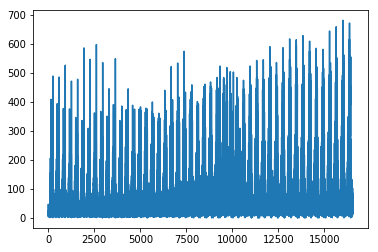

In [41]:
plt.plot(y)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y , random_state=0)

... воспользуйтесь боле подходящим из этих вариантов разбиения выборки на тестовую и обучающую. Либо любым своим вариантом разбиения.

In [43]:
print('X_train size: {}\nX_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (12402, 185)
X_test size: (4135, 185)


In [44]:
y.head()

,tranth_tst
0,21.845978
1,11.920968
2,46.845238
3,12.306839
4,3.727833


Проверим даты тестовой выборки

In [45]:
X.dtypes

report_date           datetime64[ns]
segment               object        
region                object        
compl                 float64       
segment_S_1           uint8         
segment_S_2           uint8         
segment_S_3           uint8         
segment_S_4           uint8         
segment_S_5           uint8         
region_RG_1           uint8         
region_RG_10          uint8         
region_RG_11          uint8         
region_RG_12          uint8         
region_RG_13          uint8         
region_RG_14          uint8         
region_RG_15          uint8         
region_RG_16          uint8         
region_RG_17          uint8         
region_RG_18          uint8         
region_RG_19          uint8         
region_RG_2           uint8         
region_RG_20          uint8         
region_RG_21          uint8         
region_RG_22          uint8         
region_RG_23          uint8         
region_RG_24          uint8         
region_RG_25          uint8         
r

In [46]:
kek=['lag_dollar_1','lag_dol_rab_ter_1','lag_dol_sn_nal_1','lag_dol_sn_nal_1','lag_rab_dney_1','lag_dol_sn_nal_1','']

In [47]:
X_test['report_date'].unique()

array(['2017-08-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2014-08-31T00:00:00.000000000', '2017-02-28T00:00:00.000000000',
       '2017-11-30T00:00:00.000000000', '2015-09-30T00:00:00.000000000',
       '2016-08-31T00:00:00.000000000', '2016-04-30T00:00:00.000000000',
       '2014-07-31T00:00:00.000000000', '2016-03-31T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-07-31T00:00:00.000000000',
       '2016-10-31T00:00:00.000000000', '2017-10-31T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000', '2015-01-31T00:00:00.000000000',
       '2014-03-31T00:00:00.000000000', '2015-07-31T00:00:00.000000000',
       '2014-02-28T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
       '2016-05-31T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
       '2015-06-30T00:00:00.000000000', '2017-04-30T00:00:00.000000000',
       '2015-03-31T00:00:00.000000000', '2015-02-28T00:00:00.000000000',
       '2014-11-30T00:00:00.000000000', '2016-11-30

В случае если вы считаете это необходимым, можете понизить размерность модели. 
Например, с помощью методов PCA или t-SNE. Стоит ли это делать?

MODELL SELECTION.

Выбор метода машинного обучения можно осуществлять либо экспертным путём, либо на основе статистических данных. 
На основе статистических данных, в случае если у Вас очень мощный компьютер выбор 
комбинации "метод"-"набор гиперпараметров" может осуществляться методом grid search, т.е. перебором (цикл в цикле) 
всех комбинаций методов машинного обучения и всех вариантов гиперпараметров метода из какого-либо заранее 
заданного диапазона, на основе индикаторов MSE и/или R2 на большом количестве кросс-валидаций. Именно этот подход
на данный момент используется в реальных задачах. 
В случае если ваш компьютер имеет очень мощные характеристики, вы можете использовать этот подход.
Однако, большинство слушателей курса скорее всего не имеют собственного промышленного сервера, поэтому ниже 
приведён упрощенный подход, у которого ниже корректность подбора оптимальной комбинации 
"метод"-"набор гиперпараметров", но и драматически ниже требования в ресурсам компьютера. 
В данном подходе сначала выбирается оптимальный по MSE и/или R2 метод с дефолтовыми или 
rand_state = np.random.get_state()[1][0] настройками , а уже после осуществляется sklearn.model_selection.gridsearchcv() настроек гиперпараметров. (так же для снижения ресурсоёмкости скрипта оставлена только 1 CrossValidation(CV) , однако нужно помнить, что с ростом CV увеличивается и вероятность того, что найденная комбинация "метод"-"набор гиперпараметров" будет оптимальной). Кроме того, вам стоит понимать, что вполне возможна ситуация, при которой метод, который был отброшен как неоптимальный, в упрощённом подходе, после настройки гиперпараметров может превратиться в 
наиболее оптимальный.
Если вы уверены , что какой-то метод заведомо не подходит для решения нашей задачи, то можете его закомментировать #

In [48]:
X.head()

,report_date,segment,region,compl,segment_S_1,segment_S_2,segment_S_3,segment_S_4,segment_S_5,region_RG_1,region_RG_10,region_RG_11,region_RG_12,region_RG_13,region_RG_14,region_RG_15,region_RG_16,region_RG_17,region_RG_18,region_RG_19,region_RG_2,region_RG_20,region_RG_21,region_RG_22,region_RG_23,region_RG_24,region_RG_25,region_RG_26,region_RG_27,region_RG_28,region_RG_29,region_RG_3,region_RG_30,region_RG_31,region_RG_32,region_RG_33,region_RG_34,region_RG_35,region_RG_36,region_RG_37,region_RG_38,region_RG_39,region_RG_4,region_RG_40,region_RG_41,region_RG_42,region_RG_43,region_RG_44,region_RG_45,region_RG_46,region_RG_47,region_RG_48,region_RG_49,region_RG_5,region_RG_50,region_RG_51,region_RG_52,region_RG_53,region_RG_54,region_RG_55,region_RG_56,region_RG_57,region_RG_58,region_RG_59,region_RG_6,region_RG_60,region_RG_61,region_RG_62,region_RG_63,region_RG_64,region_RG_65,region_RG_66,region_RG_67,region_RG_68,region_RG_69,region_RG_7,region_RG_70,region_RG_71,region_RG_72,region_RG_73,region_RG_74,region_RG_75,region_RG_76,region_RG_77,region_RG_78,region_RG_79,region_RG_8,region_RG_80,region_RG_81,region_RG_82,region_RG_83,region_RG_84,region_RG_85,region_RG_9,lag_dollar_1,lag_dol_rab_ter_1,lag_dol_sn_nal_1,lag_rab_dney_1,lag_atm_1,lag_cards_1,lag_tranth_tst_1,lag_dollar_2,lag_dol_rab_ter_2,lag_dol_sn_nal_2,lag_rab_dney_2,lag_atm_2,lag_cards_2,lag_tranth_tst_2,lag_dollar_3,lag_dol_rab_ter_3,lag_dol_sn_nal_3,lag_rab_dney_3,lag_atm_3,lag_cards_3,lag_tranth_tst_3,lag_dollar_4,lag_dol_rab_ter_4,lag_dol_sn_nal_4,lag_rab_dney_4,lag_atm_4,lag_cards_4,lag_tranth_tst_4,lag_dollar_5,lag_dol_rab_ter_5,lag_dol_sn_nal_5,lag_rab_dney_5,lag_atm_5,lag_cards_5,lag_tranth_tst_5,lag_dollar_6,lag_dol_rab_ter_6,lag_dol_sn_nal_6,lag_rab_dney_6,lag_atm_6,lag_cards_6,lag_tranth_tst_6,lag_dollar_7,lag_dol_rab_ter_7,lag_dol_sn_nal_7,lag_rab_dney_7,lag_atm_7,lag_cards_7,lag_tranth_tst_7,lag_dollar_8,lag_dol_rab_ter_8,lag_dol_sn_nal_8,lag_rab_dney_8,lag_atm_8,lag_cards_8,lag_tranth_tst_8,lag_dollar_9,lag_dol_rab_ter_9,lag_dol_sn_nal_9,lag_rab_dney_9,lag_atm_9,lag_cards_9,lag_tranth_tst_9,lag_dollar_10,lag_dol_rab_ter_10,lag_dol_sn_nal_10,lag_rab_dney_10,lag_atm_10,lag_cards_10,lag_tranth_tst_10,lag_dollar_11,lag_dol_rab_ter_11,lag_dol_sn_nal_11,lag_rab_dney_11,lag_atm_11,lag_cards_11,lag_tranth_tst_11,lag_dollar_12,lag_dol_rab_ter_12,lag_dol_sn_nal_12,lag_rab_dney_12,lag_atm_12,lag_cards_12,lag_tranth_tst_12,lag_dollar_13,lag_dol_rab_ter_13,lag_dol_sn_nal_13,lag_rab_dney_13,lag_atm_13,lag_cards_13,lag_tranth_tst_13
0,2014-02-28,S_1,RG_1,0.998736,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.25,0.919774,0.371817,17.0,927.0,0.0,20.312758,32.72,0.919774,0.371817,22.0,924.0,0.0,23.640372,33.19,0.919774,0.371817,20.0,894.0,0.0,21.927892,32.06,0.919774,0.371817,23.0,864.0,0.0,21.869249,32.35,0.919774,0.371817,21.0,843.0,0.0,21.553207,33.25,0.919774,0.371817,22.0,811.5,0.0,21.873778,32.89,0.919774,0.371817,23.0,802.5,0.0,21.671091,32.71,0.919774,0.371817,19.0,786.0,0.0,21.484990,31.59,0.919774,0.371817,18.0,739.5,0.0,20.999917,31.26,0.919774,0.371817,22.0,708.0,0.0,20.979533,31.08,0.919774,0.371817,20.0,684.0,0.0,18.402505,30.62,0.919774,0.371817,20.0,657.0,0.0,18.349073,30.03,0.919774,0.371817,17.0,639.0,0.0,16.936794
1,2014-02-28,S_1,RG_10,0.998741,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.25,0.936047,0.480117,17.0,249.0,0.0,11.213212,32.72,0.926895,0.464734,22.0,247.5,0.0,11.508149,33.19,0.928522,0.479749,20.0,243.0,0.0,10.719059,32.06,0.941740,0.486927,23.0,238.5,0.0,10.167730,32.35,0.953344,0.473722,21.0,213.0,0.0,9.962859,33.25,0.947516,0.498968,22.0,208.5,0.0,10.955303,32.89,0.946135,0.492546,23.0,214.5,0.0,10.624105,32.71,0.944728,0.486107,19.0,208.5,0.0,9.873830,31.59,

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import MultiTaskElasticNet
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from sklearn.isotonic import IsotonicRegression
# from xgboost import XGBRegressor

rand_state = np.random.get_state()[1][0]
ms_models_list = [
#     MLPRegressor(random_state=rand_state),
#                   GradientBoostingRegressor(random_state=rand_state),
#                   DecisionTreeRegressor(random_state=rand_state),
#                   KNeighborsRegressor(),
#                   GaussianProcessRegressor(random_state=rand_state),
#                   LinearRegression(),
                  Ridge(random_state=rand_state),
                  Lasso(random_state=rand_state),
                  MultiTaskLasso(random_state=rand_state),
#                   LassoLars(),
                  BayesianRidge(),
#                   OrthogonalMatchingPursuit(),
#                   SGDRegressor(random_state=rand_state),
#                   PassiveAggressiveRegressor(random_state=rand_state),
#                   TheilSenRegressor(random_state=rand_state),
#                   RANSACRegressor(random_state=rand_state),
#                   ElasticNet(random_state=rand_state),
#                   MultiTaskElasticNet(random_state=rand_state),
#                   ARDRegression(),
#                   HuberRegressor(),
#                   SVR(),
#                   IsotonicRegression(),
#                   XGBRegressor(seed=rand_state, nthread=32)
                 ]
ms_model_metrics_df = pd.DataFrame()
for y_cur in [predict_columns[0]]:
    for model in ms_models_list:
        t0 = time.time()
        model_metrics_tmp = {}
        model_metrics_tmp['Y'] = y_cur
        model_metrics_tmp['Model_idx'] = ms_models_list.index(model)
        model_metrics_tmp['Model_name'] = str(type(model))
        print('Process target variable: {}.\nCurrent model: {}.'.format(y_cur, type(model)))
        model.fit(X_train.drop(non_feature_columns, axis=1), y_train)
        y_test_pred = model.predict(X_test.drop(non_feature_columns, axis=1))
        model_metrics_tmp['R2'] = metrics.r2_score(y_test[y_cur].ravel(), y_test_pred.ravel())
        model_metrics_tmp['EVS'] = metrics.explained_variance_score(y_test[y_cur].ravel(), y_test_pred.ravel())
        model_metrics_tmp['MAE'] = metrics.mean_absolute_error(y_test[y_cur].ravel(), y_test_pred.ravel())
        model_metrics_tmp['MedAE'] = metrics.median_absolute_error(y_test[y_cur].ravel(), y_test_pred.ravel())
        model_metrics_tmp['MSE'] = metrics.mean_squared_error(y_test[y_cur].ravel(), y_test_pred.ravel())
        t1 = time.time()
        model_metrics_tmp['CalcTime'] = t1 - t0
        ms_model_metrics_df = ms_model_metrics_df.append([model_metrics_tmp])

Process target variable: tranth_tst.
Current model: <class 'sklearn.linear_model.ridge.Ridge'>.
Process target variable: tranth_tst.
Current model: <class 'sklearn.linear_model.coordinate_descent.Lasso'>.


Вывод результатов тестирования методов

In [ ]:
ms_model_metrics_df.sort_values(['Y', 'MSE'], ascending=True)\
[['Y', 'Model_idx', 'Model_name', 'R2', 'EVS', 'MAE', 'MedAE', 'MSE','CalcTime']]

Получен ответ на 1 вопрос теста.

Найдите оптимальные гиперпараметры выбранного метода.

Для начала заведите справочник возможных гиперпараметров метода. Помните, что для каждого метода этот справочник будет отличаться. Например, в случае если оптимальным методом был отобран GradientBoostingRegressor() подбор гиперпараметров может выглядеть следующим образом:

In [ ]:
feature_columns

In [ ]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

N_FOLD = 999 #число фолдов установите самостоятельно в соответствии с разделением train/test.
N_JOBS = 80
PARAMS = {'loss': ['ls','lad','huber','quantile'],
          'n_estimators': [25, 50, 100, 200, 300, 400, 500],
          'learning_rate': [0.01, 0.1, 0.2, 0.5 ],
          'max_depth': [1, 2, 3, 4, 5, 6, 7]
         }

y_cur = predict_columns[0]
model = GradientBoostingRegressor()
cv = GridSearchCV(estimator=model, param_grid=PARAMS, n_jobs=N_JOBS,\
                  cv=N_FOLD, refit=True, scoring='mean_squared_error')
cv.fit(X_train.drop(non_feature_columns, axis=1), y_train[[y_cur]])
y_train_pred = cv.predict(X_train.drop(non_feature_columns, axis=1))
y_test_pred = cv.predict(X_test.drop(non_feature_columns, axis=1))

Отбор значимых факторов крайне ресурсоёмкий. Поэтому, если показатель 'CalcTime' у метода, оказавшегося оптимальным,
достаточно большой, то, если вы не готовы долго ждать результатов отработки скрипта, выберите метод ближайший подходящий по этому показателю.

Отбор значимых факторов модели:

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS #SequentialFeatureSelection
feature_importances_tmp = {}
feature_importances_df = pd.DataFrame()
num_feature_columns = {}
FEATURES_LIMIT = (1,len(X.drop(non_feature_columns, axis=1).columns))
CV_LIMIT = 999 #число фолдов установите самостоятельно в соответствии с разделением train/test.
for y_cur in predict_columns:
    sfs = SFS(
              ms_models_list[ms_model_metrics_df[ms_model_metrics_df['Y']==y_cur].\
                             sort_values(by=['MSE'], ascending=True)[['Model_idx']].iloc[0,0]],
                             
              k_features=FEATURES_LIMIT,
              forward=True,
              floating=False,
              scoring='neg_mean_squared_error',
              cv=CV_LIMIT,
              n_jobs=-1)
    sfs = sfs.fit(X.drop(non_feature_columns, axis=1).values, y[y_cur].values)
    
    feature_importances_tmp.update({'Y': y_cur})
    feature_importances_tmp.update({'SFS.metric_dict': sfs.get_metric_dict()})
    feature_importances_tmp.update({'SFS.best_MSE': sfs.k_score_})
    feature_importances_tmp.update({'SFS.best_subset': list(itemgetter(list(sfs.k_feature_idx_))(X.drop(non_feature_columns, axis=1).columns))})
    feature_importances_df = feature_importances_df.append([feature_importances_tmp])
    num_feature_columns[y_cur] = dict(feature_importances_df[feature_importances_df['Y']==y_cur]\
                                      [['SFS.best_subset']].iloc[:,0])[0]
    print("Feature importances calculation for target variable '{}' complete.".format(y_cur))

При желании вы можете использовать другие методы отбора факторов. Например PCA или t-SNE, хотя на временных 
рядах не всегда они дают лучшие результаты. Достаточно не плохие результаты можно получить пакетом TSFRESH. 

In [ ]:
# Данный фрейм является исключительно ознокомительным примером использования tsfresh и если вы уже 
# выполнили SequentialFeatureSelector, то запускать его не нужно. Однако, при желании вы можете попробовать 
# отобрать факторы данным способом и посмотреть результат.
# from tsfresh.transformers import relevantfeatureaugmenter
# rfa=relevantfeatureaugmenter(column_sort='Time')
# rfa.fit(X_train, y_train)
# feature_importances_df=rfa.transform(X_test)

Вывод перечня значимых факторов.

In [ ]:
feature_importances_df[['Y','SFS.best_MSE','SFS.best_subset']]

Получен ответ на 2,3,4 вопросы теста

Если вы наверняка знаете факторы, которые должны быть в моделе, то можно их добавить вручную.
Если такой необходимости нет, то можно пропустить следующий кусочек кода.

In [ ]:
num_feature_columns_add = {}
for y_cur in predict_columns:
    num_feature_columns_add[y_cur] =[] #закомментировать данную строку
    #['','','',''] - ввести перечень требуемых факторов
    #num_feature_columns[y_cur] = [] # раскомментировать данную строку

График зависимости качества модели от числа факторов.

In [ ]:
for y_cur in [predict_columns[0]]:
    metric_dict = dict(feature_importances_df[feature_importances_df['Y']==y_cur]\
                       [['SFS.metric_dict']].iloc[:,0])[0]
    plt.figure()
    fig = plot_sfs(metric_dict, kind='std_err')
    plt.title('Sequential Feature Selection (w. StdErr) for {}'.format(y_cur))
    plt.grid()
plt.show()

Выберите верный из двух указанных ниже вариантов прогноза. Нужно ли запускать эти две части обе последовательно?

In [ ]:
# Расчёт прогноза (Вариант1)
y_cur = predict_columns[0]
model = ms_models_list[ms_model_metrics_df[ms_model_metrics_df['Y']==y_cur].\
                       sort_values(by=['MSE'], ascending=True)[['Model_idx']].iloc[0,0]]
model.fit(X_train[num_feature_columns[y_cur]+num_feature_columns_add[y_cur]], y_train[[y_cur]])
y_train_pred = model.predict(X_train[num_feature_columns[y_cur]+num_feature_columns_add[y_cur]])
y_test_pred = model.predict(X_test[num_feature_columns[y_cur]+num_feature_columns_add[y_cur]])

In [ ]:
#Расчёт прогноза (Вариант2)
y_cur = predict_columns[0]
model = ms_models_list[ms_model_metrics_df[ms_model_metrics_df['Y']==y_cur].\
sort_values(by=['MSE'], ascending=True)[['Model_idx']].iloc[0,0]]
y_test_pred = model.predict(X_test[num_feature_columns[y_cur]+num_feature_columns_add[y_cur]])

Результаты прогноза.

In [ ]:
y_cur = predict_columns[0]

plt.figure(figsize=(15, 5))
plt.plot(y_train_pred.ravel(), label='y_train_pred')
plt.plot(y_train[y_cur].ravel(), label='y_train')

plt.legend(loc='best')
plt.axis('tight')
plt.grid(True)
plt.title('XGB R2: {}, EVS: {}, MAE: {}, MedAE: {}, MSE: {}'.\
          format(round(metrics.r2_score(y_train_pred.ravel(), y_train[y_cur].ravel()),3),\
                 round(metrics.explained_variance_score(y_train_pred.ravel(), y_train[y_cur].ravel()),3),\
                 
                 round(metrics.mean_absolute_error(y_train_pred.ravel(), y_train[y_cur].ravel()),3),\
                 round(metrics.median_absolute_error(y_train_pred.ravel(), y_train[y_cur].ravel()),3),\
                 round(metrics.mean_squared_error(y_train_pred.ravel(), y_train[y_cur].ravel()),3)))
plt.figure(figsize=(15, 5))
plt.plot(y_test_pred.ravel(), label='y_test_pred')
plt.plot(y_test[y_cur].ravel(), label='y_test')
plt.legend(loc='best')
plt.axis('tight')

plt.grid(True)
plt.title('XGB R2: {}, EVS: {}, MAE: {}, MedAE: {}, MSE: {}'.\
          format(round(metrics.r2_score(y_test_pred.ravel(), y_test[y_cur].ravel()),3),\
                 round(metrics.explained_variance_score(y_test_pred.ravel(), y_test[y_cur].ravel()),3),\
                 round(metrics.mean_absolute_error(y_test_pred.ravel(), y_test[y_cur].ravel()),3),\
                 round(metrics.median_absolute_error(y_test_pred.ravel(), y_test[y_cur].ravel()),3),\
                 round(metrics.mean_squared_error(y_test_pred.ravel(), y_test[y_cur].ravel()),3)))

Расчёт результата.

In [ ]:
X_test.columns

In [ ]:
y_cur = predict_columns[0]
output_df_train = X_test.reset_index(drop=True)[['report_date','segment', 'region']].\
join(y_test.reset_index(drop=True)[[y_cur]].rename(columns={y_cur: 'y_test_fact'})).\
join(pd.DataFrame(y_test_pred).rename(columns={0:'y_test_pred'}))

In [ ]:
y_cur = predict_columns[0]
output_df_predict = X_test.reset_index(drop=True)[['report_date','segment', 'region']].\
join(pd.DataFrame(y_test_pred).rename(columns={0:'y_test_pred'}))

Выгрузка результата.

In [ ]:
FILE_NAME = '###.csv' #укажите имя файла
output_df_train.to_csv(FILE_NAME, sep=';', encoding='utf-8', header=True, index=True)

Если у вас уже есть начальное приближение на прогнозный период, то после получения модели (метод+гиперпараметры+фичи)
можно обучить модель на всех данных (100% обучающая выборка, а прогноз делать на имеющемся начальном приближении).
Либо, вводить полученные результаты итерационно для каждого последующего месяца, принимая полученный прогноз для i-ого 
месяца, как факт, для i+1 месяца. 

Получены ответы на 5, 6, 7, 8 вопросы теста